# NLP From Scratch
## Generating Names with a Character-Level RNN

In [1]:
# Based on the Pytorch Tutorial:
# https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [2]:
import time
import math
import io
import glob
import os
from pathlib import Path
import unicodedata
import string
import random
import requests
from zipfile import ZipFile

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# Download the file
url = 'https://download.pytorch.org/tutorial/data.zip'
response = requests.get(url)

# Unzip the file
with ZipFile(io.BytesIO(response.content)) as z:
    z.extractall()  # You can also specify the directory to extract the files.

print('Download and extraction complete!')

Download and extraction complete!


In [6]:
def find_files(path):
    return glob.glob(path)

In [7]:
# Show the txt files in the directory:
for f in find_files('./data/names/*.txt'):
    print(f)
    # print(f.split('/')[-1])

./data/names/Scottish.txt
./data/names/German.txt
./data/names/Greek.txt
./data/names/English.txt
./data/names/Polish.txt
./data/names/Czech.txt
./data/names/Spanish.txt
./data/names/Russian.txt
./data/names/Irish.txt
./data/names/Vietnamese.txt
./data/names/Arabic.txt
./data/names/Portuguese.txt
./data/names/Japanese.txt
./data/names/French.txt
./data/names/Italian.txt
./data/names/Korean.txt
./data/names/Chinese.txt
./data/names/Dutch.txt


In [8]:
letters = string.ascii_letters + " .,;'"
n_letters = len(letters)
letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [9]:
n_letters

57

### Fetch the Data

In [10]:
# https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string/518232#518232
def unicode2ascii(s):
    """
    Trun a Unicode string to plain ASCII.
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in letters
    )

In [11]:
unicode2ascii('Ślusàrski')

'Slusarski'

In [12]:
def read_lines(file_name):
    with open(file_name, encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
    return [unicode2ascii(line) for line in lines]

In [13]:
path_files = find_files('./data/names/*.txt')
print(f'Found {len(path_files)} files.')

Found 18 files.


In [14]:
path_files[0]

'./data/names/Scottish.txt'

In [15]:
os.path.splitext(os.path.basename(path_files[0]))

('Scottish', '.txt')

In [16]:
path_files[0].split('/')[-1].split('.')

['Scottish', 'txt']

In [17]:
Path(path_files[0]).stem

'Scottish'

In [18]:
names_dict = {}
for file in path_files:
    lang = Path(file).stem
    lines = read_lines(file)
    names_dict[lang] = lines

In [19]:
list(names_dict.keys())

['Scottish',
 'German',
 'Greek',
 'English',
 'Polish',
 'Czech',
 'Spanish',
 'Russian',
 'Irish',
 'Vietnamese',
 'Arabic',
 'Portuguese',
 'Japanese',
 'French',
 'Italian',
 'Korean',
 'Chinese',
 'Dutch']

In [20]:
# How many names in each category/language:
name_cnt_lst = [(lang, len(names_dict[lang])) for lang in names_dict]
sorted(name_cnt_lst, key=lambda x: x[1], reverse=True)

[('Russian', 9408),
 ('English', 3668),
 ('Arabic', 2000),
 ('Japanese', 991),
 ('German', 724),
 ('Italian', 709),
 ('Czech', 519),
 ('Spanish', 298),
 ('Dutch', 297),
 ('French', 277),
 ('Chinese', 268),
 ('Irish', 232),
 ('Greek', 203),
 ('Polish', 139),
 ('Scottish', 100),
 ('Korean', 94),
 ('Portuguese', 74),
 ('Vietnamese', 73)]

In [21]:
# Totall number of names:
sum(len(names_dict[lang]) for lang in names_dict)

20074

In [22]:
# For every file/language there should be a key in the `names_dict`
assert len(names_dict.keys()) == len(path_files)

In [23]:
names_dict['Italian'][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

In [24]:
def letter2tensor(letter):
    """
    Each letter is represented via "one-hot-vector of size:
    <1 x len(letters)>
    `letters` is our vocabulary of all the available letters.
    """
    # Get index of the letter in our *vocab* (letters):
    idx = letters.find(letter)
    # Create a 1hot-encode of the letter:
    t = torch.zeros(1, len(letters))
    t[0][idx] = 1  # all zero but its index in the vocab/letters.
    return t

In [25]:
h = letter2tensor('a')
h

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [26]:
h.size()

torch.Size([1, 57])

In [27]:
def line2tensor(line):
    tensor_lst = [letter2tensor(letter).unsqueeze(0) for letter in line]
    return torch.cat(tensor_lst, dim=0)

In [28]:
line2tensor('torch')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [29]:
line2tensor('torch').size()

torch.Size([5, 1, 57])

## Create the Network

In [30]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [31]:
HIDDEN_SIZE = 128
OUTPUT_SIZE = len(names_dict.keys())
# initialize the model:
rnn = VanillaRNN(len(letters), HIDDEN_SIZE, OUTPUT_SIZE)

In [32]:
out, next_h = rnn(letter2tensor('A'), torch.zeros(1, HIDDEN_SIZE))

In [33]:
out  # probability

tensor([[-2.7144, -3.0431, -2.9779, -2.8620, -2.8765, -2.7689, -2.8551, -2.9864,
         -2.9697, -2.9200, -2.9481, -2.8014, -2.8186, -2.9337, -2.9188, -2.8147,
         -2.9269, -2.9538]], grad_fn=<LogSoftmaxBackward0>)

In [34]:
next_h

tensor([[ 0.0718,  0.0506,  0.0898, -0.0643, -0.1528, -0.1589,  0.1002, -0.0767,
          0.0595, -0.1123, -0.2378, -0.0480,  0.1263,  0.0947, -0.1481,  0.1257,
          0.0772,  0.0508,  0.0545, -0.0663, -0.0806,  0.0465, -0.0901, -0.0142,
          0.0378,  0.1097,  0.0962,  0.0610, -0.0668,  0.0815, -0.0771,  0.0802,
          0.1253,  0.0547, -0.0168,  0.0826, -0.1825, -0.1053, -0.0015,  0.1798,
         -0.1052, -0.0381,  0.0797, -0.0629,  0.0227,  0.1984, -0.0502,  0.0254,
          0.1726, -0.0307, -0.0950, -0.0122,  0.0686,  0.0551, -0.1548, -0.0368,
          0.1669,  0.2414, -0.0694, -0.0912, -0.0231, -0.0230,  0.0156,  0.2187,
          0.1769,  0.0551,  0.0266, -0.0293,  0.2152,  0.0353,  0.0947, -0.1074,
          0.1727,  0.0122, -0.0565, -0.1034, -0.0140,  0.0032, -0.0284,  0.0733,
          0.1186,  0.0016,  0.0027, -0.1742, -0.1460,  0.1093, -0.1196,  0.2419,
          0.0957,  0.0371, -0.1404, -0.1262,  0.1447, -0.0296, -0.1916,  0.0045,
         -0.1019,  0.0334, -

In [35]:
next_h.size()

torch.Size([1, 128])

In [36]:
out.topk(1)

torch.return_types.topk(
values=tensor([[-2.7144]], grad_fn=<TopkBackward0>),
indices=tensor([[0]]))

In [37]:
langs = list(names_dict.keys())

def get_likely_lang(output):
    max_val, max_idx = output.topk(1)
    cat_idx = max_idx.squeeze().item()
    return langs[cat_idx], cat_idx

In [38]:
get_likely_lang(out)

('Scottish', 0)

In [39]:
def get_rnd_example():
    """Randomly pick a name & its language."""
    lang = random.choice(langs)
    name = random.choice(names_dict[lang])
    lang_tensor = torch.tensor([langs.index(lang)], dtype=torch.long)
    name_tensor = line2tensor(name)
    return (lang, name), (lang_tensor, name_tensor)


In [40]:
for _ in range(10):
    res, res_tensor = get_rnd_example()
    lang, name = res
    print(f'language = {lang}/ name = {name}')

language = English/ name = Franklin
language = Russian/ name = Mihelyus
language = Arabic/ name = Issa
language = French/ name = Lemieux
language = Korean/ name = Nam
language = Chinese/ name = Thean
language = Greek/ name = Gianakopulos
language = Korean/ name = Byon
language = Chinese/ name = Ran
language = Greek/ name = Sakellariou


## Training the Network

Now all it takes to train the network is to show it a bunch of examples, have it make guesses, and tell it if it's wrong.   

For the loss function `nn.NLLLoss` is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.

In [41]:
criterion = nn.NLLLoss()

In [42]:
def train(lang, name):
    """
    Training phase.
    lang & name are tensors.
    """
    hidden = rnn.init_hidden()  # create a zeroed initial hidden state

    rnn.zero_grad()

    for i in range(name.size()[0]):
        output, hidden = rnn(name[i], hidden)

    loss = criterion(output, lang)
    loss.backward()

    # Add parametes' gradients to their values, multiplied by lr.
    for param in rnn.parameters():
        param.data.add_(param.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [43]:
def time_since_min_sec(start):
    seconds = time.time() - start
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return f'{minutes}m - {int(seconds)}s'


In [44]:
t0 = time.time()
time.sleep(19)
time_since_min_sec(t0)

'0m - 19s'

In [46]:
N_ITERATIONS = int(2e5)

PRINT_EVERY = 10000
PLOT_EVERY  = 2000

learning_rate = .001
# Keep track of losses for plotting.
current_loss = 0
loss_lst = []


t0 = time.time()
for i in range(1, N_ITERATIONS+1):
    lang_name, lang_name_tensor = get_rnd_example()
    output, loss = train(*lang_name_tensor)
    current_loss += loss

    # Print `epoch` number, loss, name, and guess:
    lang, name = lang_name
    if i == 1 or i % PRINT_EVERY == 0:
        guess, guess_idx = get_likely_lang(output)
        correct = '✓' if guess == lang else f'✗ ({lang})'
        print(
            f'EPOCH [{i}/{N_ITERATIONS}] {i*100/N_ITERATIONS:.0f}% ',
            f'({time_since_min_sec(t0)}), Loss: {loss:.4f} ',
            f'{name} / {guess} {correct}'
        )

    if i == 1 or i % PLOT_EVERY == 0:
        loss_lst.append(current_loss / PLOT_EVERY)
        current_loss = 0

EPOCH [1/200000] 0%  (0m - 0s), Loss: 2.8321  Asghar / Czech ✗ (Arabic)
EPOCH [10000/200000] 5%  (0m - 21s), Loss: 2.6812  Jagoda / Japanese ✗ (Polish)
EPOCH [20000/200000] 10%  (0m - 42s), Loss: 1.4734  Dam / Chinese ✗ (Vietnamese)
EPOCH [30000/200000] 15%  (1m - 3s), Loss: 1.8941  Roosevelt / Dutch ✓
EPOCH [40000/200000] 20%  (1m - 24s), Loss: 2.7288  Sauvageot / Russian ✗ (French)
EPOCH [50000/200000] 25%  (1m - 44s), Loss: 0.2956  Sokolowski / Polish ✓
EPOCH [60000/200000] 30%  (2m - 8s), Loss: 1.4403  Faltysek / Polish ✗ (Czech)
EPOCH [70000/200000] 35%  (2m - 28s), Loss: 1.5348  Franco / Spanish ✗ (Portuguese)
EPOCH [80000/200000] 40%  (2m - 50s), Loss: 2.3794  Esenchuk / Czech ✗ (Russian)
EPOCH [90000/200000] 45%  (3m - 11s), Loss: 3.1156  Gavril / French ✗ (Greek)
EPOCH [100000/200000] 50%  (3m - 31s), Loss: 1.8413  Traversa / Portuguese ✗ (Italian)
EPOCH [110000/200000] 55%  (3m - 53s), Loss: 1.0738  Mach / Vietnamese ✓
EPOCH [120000/200000] 60%  (4m - 13s), Loss: 0.0832  Bart

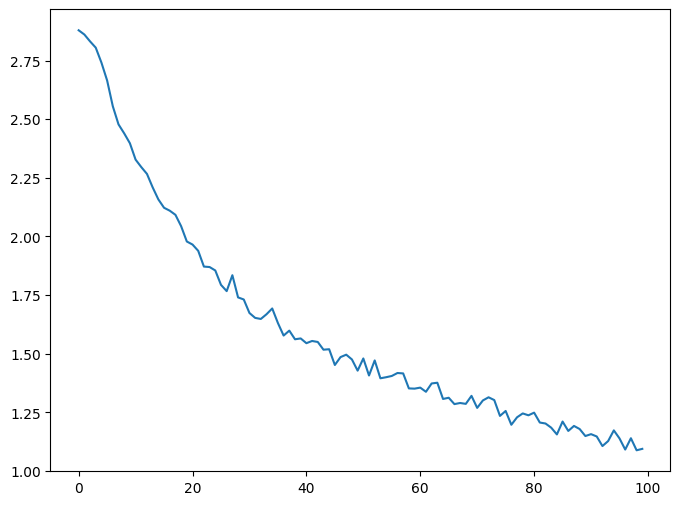

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(loss_lst[1:])

## Evaluating the results

In [48]:
conf_matrix = torch.zeros(len(langs), len(langs))

def evaluate(name):
    """
    Retruns the prediction given the name.
    name: tensor
    """
    hidden = rnn.init_hidden()

    for i in range(name.size()[0]):
        output, hidden = rnn(name[i], hidden)

    return output

In [49]:
# Go through a bunch of examples and record whic are correctly guessed:
len_tst_examples = 10000

for i in range(len_tst_examples):
    _, res = get_rnd_example()
    lang, name = res
    output = evaluate(name)
    guess, guess_idx = get_likely_lang(output)
    lang_idx = langs.index(_[0])
    conf_matrix[lang_idx][guess_idx] += 1

# Normalize by dividing each row by its sum:
for i in range(len(langs)):
    conf_matrix[i] = conf_matrix[i] / conf_matrix[i].sum()

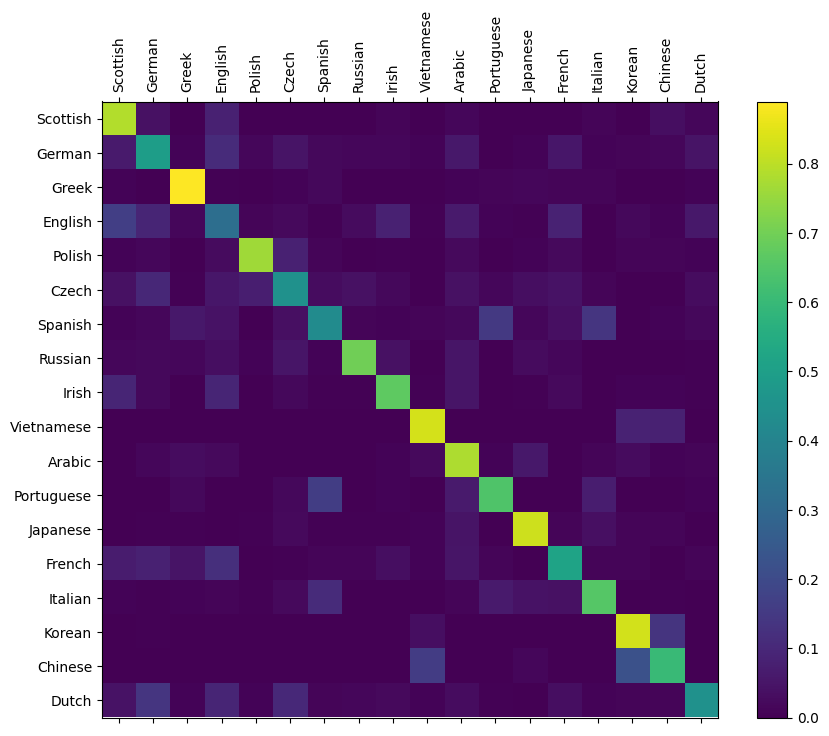

In [50]:
# Set up confusion matrix plot:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix.numpy())
fig.colorbar(cax)

# Set tick positions and labels
ax.set_xticks(range(len(langs)))
ax.set_xticklabels(langs, rotation=90)
ax.set_yticks(range(len(langs)))
ax.set_yticklabels(langs)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [51]:
# Bright spots off the main axis show which language is guessed incorrectly.
# It seems to do well with Greek;
# also, very poorly with English (perhaps because of overlap with other languages?)

## Predict on User Input

In [52]:
def predict(name, n_predictions=3):
    print(f'\n> {name}')
    with torch.inference_mode():
        output = evaluate(line2tensor(name))
        preds = F.softmax(output, dim=1)
    # Get top categories:
    topv, topi = preds.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i].item()
        lang_idx = topi[0][i].item()
        print(f'({value*100:.2f}%) {langs[lang_idx]}')
        predictions.append((value, langs[lang_idx]))

    return predictions

In [53]:
_ = predict('Dovesky')


> Dovesky
(54.67%) Czech
(35.12%) Russian
(4.59%) English


In [54]:
_ = predict('Satoshi')


> Satoshi
(54.17%) Japanese
(38.45%) Arabic
(3.53%) Italian


In [55]:
_ = predict('Hesch')


> Hesch
(43.36%) Czech
(24.69%) German
(10.98%) English
